In [1]:
%%time
from data import data
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

data.download()
iamges_dir = data.process_gs_rainfall_daily()

n_images = 100
image_files = sorted(glob(iamges_dir + '/*.npy'))[:n_images]

images = np.array([
                    np.load(image) for image in image_files
                    ])

print(images.shape)
image_size = images.shape[-2:]

train_n = 80
train = images[:train_n]
test = images[train_n:]

(100, 600, 1800)
CPU times: user 861 ms, sys: 494 ms, total: 1.35 s
Wall time: 1.18 s


[[0.         0.         0.         ... 0.5058824  0.49803922 0.5254902 ]
 [0.         0.         0.         ... 0.5019608  0.5058824  0.50980395]
 [0.         0.         0.         ... 0.50980395 0.5137255  0.50980395]
 ...
 [0.5921569  0.5882353  0.58431375 ... 0.49803922 0.49019608 0.4627451 ]
 [0.59607846 0.59607846 0.5921569  ... 0.4509804  0.4627451  0.46666667]
 [0.5882353  0.5882353  0.5764706  ... 0.44705883 0.48235294 0.5058824 ]]
float32
0.21697377


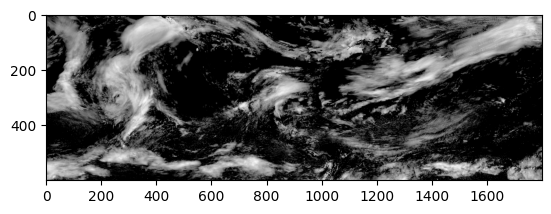

In [2]:
"""
plt.subplots(1, 2)

plt.subplot(1, 2, 1)
ref_image = plt.imread(image_files[0])
print(ref_image)
print(ref_image.dtype)
print(ref_image
plt.imshow(ref_image, cmap='gray')

plt.subplot(1, 2, 2)
"""
sref_image = images[0]
print(sref_image)
print(sref_image.dtype)
print(sref_image.mean())
plt.imshow(sref_image, cmap='gray')

In [3]:
def batch(imgs_arr, seq_len, batch_size):
    """
    seq_len should include the label image
    Note: Lazy load and make individual batches during training/testing
    """
    
    n_batches = len(imgs_arr) // (seq_len * batch_size)
    
    X = np.array([
                    np.array([
                                imgs_arr[
                                    batch_n * batch_size * seq_len + seq_n * seq_len:
                                    batch_n * batch_size * seq_len + seq_n * seq_len + seq_len - 1
                                ].reshape(seq_len - 1, 1, *image_size) # Explicit single gs channel
                                for seq_n in range(batch_size)
                    ])
                    for batch_n in range(n_batches)
                ])
    y = np.array([
                    np.array([
                                imgs_arr[
                                    batch_n * batch_size * seq_len + seq_n * seq_len + seq_len - 1
                                ].reshape(1, *image_size) # Explicit single gs channel
                                for seq_n in range(batch_size)
                    ])
                    for batch_n in range(n_batches)
                ])
    return X, y

In [4]:
%%time

seq_len = 5
batch_size = 1

X_train_batch, y_train_batch = batch(train, seq_len=seq_len, batch_size=batch_size)

X_train_batch.shape, y_train_batch.shape

CPU times: user 82.9 ms, sys: 57.4 ms, total: 140 ms
Wall time: 141 ms


((16, 1, 4, 1, 600, 1800), (16, 1, 1, 600, 1800))

In [5]:
import torch
from torch import nn


class ConvRNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, kernal_size_, padding_, out_size=1):
        super(ConvRNN, self).__init__()
        self.hidden_channels = hidden_channels
        self.conv1 = nn.Conv2d(in_channels + hidden_channels, hidden_channels, kernel_size=kernal_size_, padding=padding_)
        self.conv2 = nn.Conv2d(hidden_channels, hidden_channels, kernel_size=kernal_size_, padding=padding_)
        self.conv3 = nn.Conv2d(hidden_channels, in_channels, kernel_size=kernal_size_, padding=padding_)

    def forward(self, in_tensor, h):
        h = torch.cat((in_tensor, h), dim=1)
        h = torch.tanh(self.conv1(h))
        h = torch.tanh(self.conv2(h))
        return self.conv3(h), h

    def init_hidden(self, batch_size, img_size):
        return torch.zeros(batch_size, self.hidden_channels, *img_size)

CPU times: user 26.5 s, sys: 11.7 s, total: 38.1 s
Wall time: 21.5 s


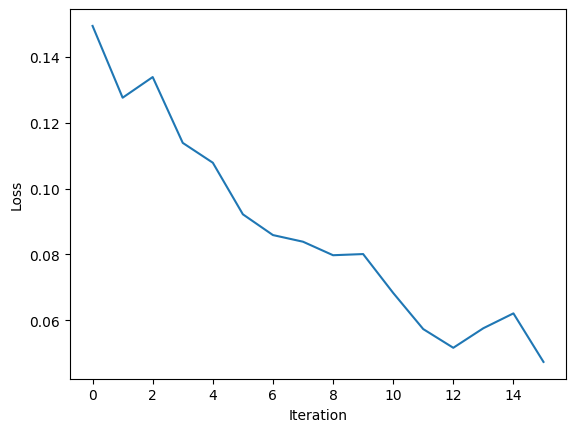

In [6]:
%%time

X_train = torch.from_numpy(X_train_batch)
y_train = torch.from_numpy(y_train_batch)

in_channels = X_train_batch.shape[3]
hidden_channels = 2

model = ConvRNN(in_channels, hidden_channels, kernal_size_=3, padding_=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
train_losses = []

for X_batch, y_batch in zip(X_train, y_train):

    hidden = model.init_hidden(batch_size, X_batch.shape[-2:])
    for step in range(seq_len - 1 - 1):
        _, hidden = model(X_batch[:,step], hidden)

    y_pred, _ = model(X_batch[:, -1], hidden)
    loss = criterion(y_pred, y_batch)
    train_losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Plot the training loss curve
plt.plot(train_losses)
plt.xlabel("Iteration")
plt.ylabel("Loss");

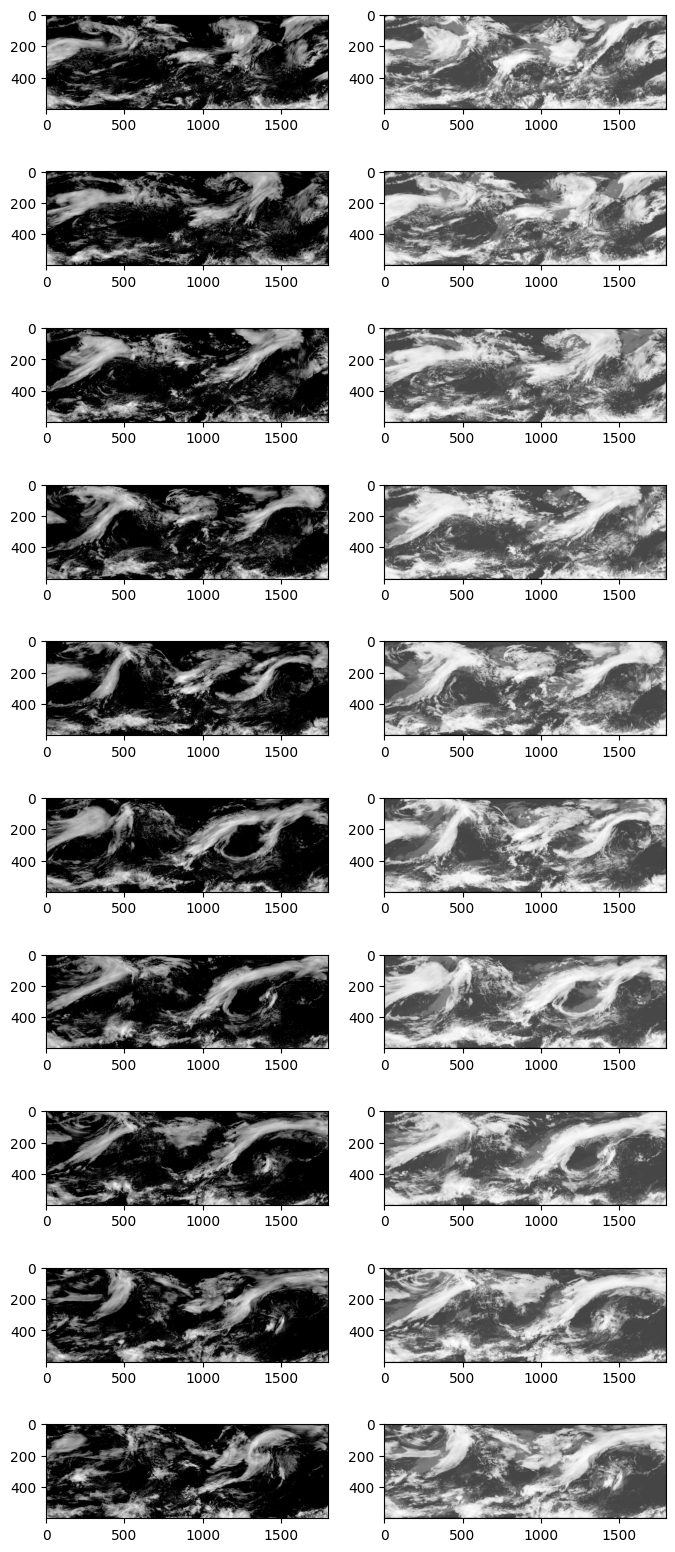

In [7]:
def predict(m, X_test):
    """ Assuming batch_size = 1 """
    
    hidden = m.init_hidden(batch_size, image_size)
    
    for step in range(seq_len - 1 - 1):
        _, hidden = model(X_test[:,step], hidden)

    pred, _ = model(X_test[:, -1], hidden)
    return pred.detach().numpy().reshape(*image_size)

n_days = 10
cols = 2
fig, axs = plt.subplots(n_days, cols, figsize=(8, 2*n_days))

model.eval()

for i in range(n_days):

    # Get predicted
    X = np.array([
                    images[
                            len(train) - (seq_len - 1) + i:
                            len(train) + i
                            ].reshape(seq_len - 1, 1, *image_size) # Explicit single gs channel
                            for seq_n in range(batch_size)
                ])
    y = images[len(train) + i]
    y_pred = predict(model, torch.from_numpy(X))

    # Plot real
    plt.subplot(n_days, cols, i * cols + 1)
    plt.imshow(y.astype('float32') * 255., cmap='gray')

    # Plot predicted
    plt.subplot(n_days, cols, i * cols + 2)
    plt.imshow(y_pred.astype('float32') * 255., cmap='gray')